In [37]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import math
from sklearn.model_selection import train_test_split
import time

## Post processing using KNN

In [2]:
# import dataset
q = pd.read_csv('../output/q.csv')
q.drop(['Unnamed: 0'], axis = 1, inplace=True)

# convert dataframe into a matrix
q_mat = q.to_numpy()
q_mat = np.transpose(q_mat)

In [3]:
# calculate mean rating for each movie
rating = pd.read_csv('../data/ml-latest-small/ratings.csv')
rating = rating[['movieId','rating']]
y = rating.groupby(['movieId']).mean()

### Choose the optimal K using Grid search CV

In [4]:
# create a KNN regression model
knn_model = KNeighborsRegressor(metric = 'cosine', algorithm='brute')

# define parameters
param_grid = {'n_neighbors': np.arange(60, 100)}

# create grid search CV
knn_gscv = GridSearchCV(knn_model, param_grid, cv=5, scoring = 'neg_mean_squared_error')

# fit to our data
knn_gscv.fit(q_mat, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='brute', leaf_size=30,
                                           metric='cosine', metric_params=None,
                                           n_jobs=None, n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
       94, 95, 96, 97, 98, 99])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [5]:
# the best knn parameter
knn_gscv.best_params_

{'n_neighbors': 96}

In [6]:
# RMSE of our KNN model
math.sqrt(-1*knn_gscv.best_score_)

0.8723211393246438

Text(0, 0.5, 'RMSE')

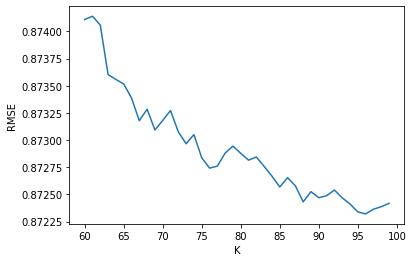

In [7]:
# get RMSE for each K 
all_rmse = np.sqrt(-1*knn_gscv.cv_results_['mean_test_score'])
k = range(60,100)

# visualize RMSE w.r.t K
plt.plot(k, all_rmse)
plt.xlabel('K')
plt.ylabel('RMSE')

In [8]:
# make predictions
rating_pred = knn_gscv.predict(q_mat)

## Combine all component to fit Linear Regression

In this step, we will combine all the component, including $p_i^Tq_i$, $b_i$, $b_u$, $b_{i,Bin(t)}$, and $KNN$, to construct a linear regression function to make predictions for the ratings.

In [9]:
## fit linear regression function on all component
# import data
p = pd.read_csv('../output/p.csv')
b_user = pd.read_csv('../output/b_user.csv')
b_movie = pd.read_csv('../output/b_movie.csv')
mu = pd.read_csv('../output/mu.csv')
b_bin = pd.read_csv('../output/b_bin.csv')

In [10]:
# clean data
p.drop(['Unnamed: 0'], axis = 1, inplace=True)
b_user.drop(['Unnamed: 0'], axis = 1, inplace=True)
b_movie.drop(['Unnamed: 0'], axis = 1, inplace=True)
b_bin.drop(['Unnamed: 0'], axis = 1, inplace=True)

# convert into matrix
p_mat = p.to_numpy()
b_user_mat = b_user.to_numpy()
b_movie_mat = b_movie.to_numpy()
b_bin_mat = b_bin.to_numpy()

In [11]:
# comput interaction matrix
interaction = np.matmul(q_mat, p_mat)

### Flatten every component to single column vector in order to do Linear Regression

In our case, our data has three dimension, which are 9724 movies, 610 users, and 30 bins, we want to flatten each component into a $(9724*610*30)*1$ column vector in order to constrcut the linear regression function.

In [12]:
# flatten interaction matrix
inter_flat = []

for col in range(interaction.shape[1]):
    inter_flat.append(interaction[:,col].tolist())
    
li = list(chain.from_iterable(inter_flat))

# repeat for 30 times
inter_flat_time = []
for i in range(30):
    for ele in li:
        inter_flat_time.append(ele)

In [13]:
# repear b_user for every movie
b_user_flat = []
for ele in b_user_mat.tolist():
    for i in range(9724):
        b_user_flat.append(ele)
        
b_user_flat = list(chain.from_iterable(b_user_flat))

# repeat for 30 times
b_user_flat_time = []
for i in range(30):
    for ele in b_user_flat:
        b_user_flat_time.append(ele)

In [14]:
# repear b_movie for every user
b_movie_flat = []
for i in range(610):
    b_movie_flat.append(b_movie_mat[:,0].tolist())
        
b_movie_flat = list(chain.from_iterable(b_movie_flat))

# repeat for 30 times
b_movie_flat_time = []
for i in range(30):
    for ele in b_movie_flat:
        b_movie_flat_time.append(ele)

In [15]:
# repear KNN for every user
rating_pred_flat = []
for i in range(610):
    rating_pred_flat.append(rating_pred[:,0].tolist())
        
rating_pred_flat = list(chain.from_iterable(rating_pred_flat))

# repeat for 30 times
rating_pred_flat_time = []
for i in range(30):
    for ele in rating_pred_flat:
        rating_pred_flat_time.append(ele)

In [16]:
# flatten b_bin for 30 bins
b_bin_mat = np.transpose(b_bin_mat)
b_bin_flat = []

for col in range(30):
    for i in range(610):
        b_bin_flat.append(b_bin_mat[:,col].tolist())

b_bin_flat = list(chain.from_iterable(b_bin_flat))

In [17]:
# calcualte y vec for linear regression
y_mat = y.to_numpy()
y_flat = []
for i in range(610):
    y_flat.append(y_mat[:,0].tolist())
        
y_flat = list(chain.from_iterable(y_flat))

# repeat for 30 times
y_flat_time = []
for i in range(30):
    for ele in y_flat:
        y_flat_time.append(ele)

In [18]:
# combine all component into X matrix 
inter_df = pd.DataFrame(inter_flat_time, columns = ['Interaction'])
b_user_df =  pd.DataFrame(b_user_flat_time, columns = ['b_user'])
b_movie_df =  pd.DataFrame(b_movie_flat_time, columns = ['b_movie'])
b_bin_df =  pd.DataFrame(b_bin_flat, columns = ['b_bin'])
knn_df =  pd.DataFrame(rating_pred_flat_time, columns = ['KNN'])

X = pd.concat([inter_df, b_user_df, b_movie_df, b_bin_df, knn_df], axis = 1, sort=False)

In [19]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_flat_time, test_size=0.2, random_state=42)

In [38]:
# fit linear regression
start = time.time()
reg = LinearRegression().fit(X_train,y_train)
end = time.time()



In [39]:
# calculate training time 
model_train_tm = end-start
print('model training took: {}'.format(model_train_tm))

model training took: 2420.9919040203094


In [21]:
# get parameters of the linear regression
reg.coef_

array([-8.71442790e-04, -1.17177633e-04,  9.02358273e-01,  2.05943752e-02,
        7.17274727e-01])

In [34]:
# make predictions
y_pred = reg.predict(X_test)

In [35]:
# compute MSE
mse = (((y_pred - np.array(y_test))**2).sum()) / len(y_test)

In [36]:
# compute RMSE
RMSE = math.sqrt(mse)
RMSE

0.7006995462907598